# Обзор систематик

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
def calc_cs_born(df):
    cs_born = df['n_sig_exp']/(df['lum']*df['eff0']*df['eff_trig']*df['rad']*df['dccorr'])
    cs_born_err = cs_born*df['rad']*np.sqrt( (df['n_sig_exp_err']/df['n_sig_exp'])**2 +
        (df['lum_err']/df['lum'])**2 + (df['eff0_err']/df['eff0'])**2 + (df['eff_trig_err']/df['eff_trig'])**2 + 
                                           (df['dccorr_err']/df['dccorr'])**2) #не делю на рад.поправку
    return (cs_born, cs_born_err)
def get_cs(season, dropna=False):
    df_signal = pd.read_csv(f'../data/{season}/results/signal.csv', index_col=0)
    df_reg_eff = pd.read_csv(f'../data/{season}/results/reg_eff.csv', index_col=0)
    df_triggers = pd.read_csv(f'../data/{season}/results/triggers.csv', index_col=0)
    df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{season}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
    df_dc = pd.read_csv(f'../data/{season}/results/dc_n2.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/dc_n2.csv') else pd.DataFrame({'dccorr': 1, 'dccorr_err': 0}, index=df_signal.index)
    df_rads = pd.read_csv(f'../data/{season}/results/radcors_n.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/radcors_n.csv') else pd.DataFrame({'rad': 1, 'rad_err': 0}, index=df_signal.index)
    df = pd.concat([df_signal, df_reg_eff, df_triggers, df_lum, df_dc, df_rads], axis=1)
    df.rad.fillna(1, inplace=True)
    df.rad_err.fillna(0, inplace=True)
    df['cs_born'], df['cs_born_err'] = calc_cs_born(df)
    df['season'] = season
    if dropna:
        df.dropna(inplace=True)
    return df

## Посмотрю на то, что у меня есть

In [4]:
SEASONS = ['11', '12', '17', '19', '20']
cs = {s: get_cs(s, True) for s in SEASONS}

### Статистическая ошибка числа событий

Stat Error season 11: mean 23.3%, median 18.0%
Stat Error season 12: mean 25.4%, median 24.1%
Stat Error season 17: mean 27.5%, median 26.7%
Stat Error season 19: mean 20.6%, median 13.2%
Stat Error season 20: mean 13.7%, median 13.5%


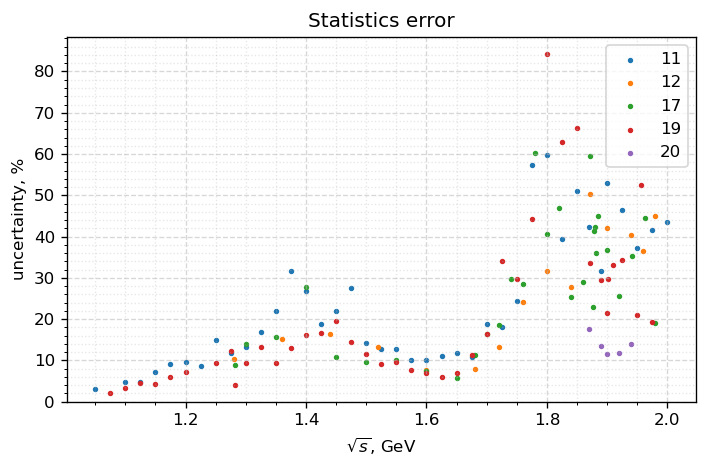

In [5]:
for s in cs:
    stat_err = cs[s]['n_sig_exp_err']/cs[s]['n_sig_exp']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'Stat Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('Statistics error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### Триггеры
Как оценить систематику от корреляций?

Trig Error season 11: mean 6.7%, median 4.2%
Trig Error season 12: mean 4.2%, median 3.6%
Trig Error season 17: mean 2.1%, median 1.4%
Trig Error season 19: mean 0.4%, median 0.2%
Trig Error season 20: mean 0.1%, median 0.1%


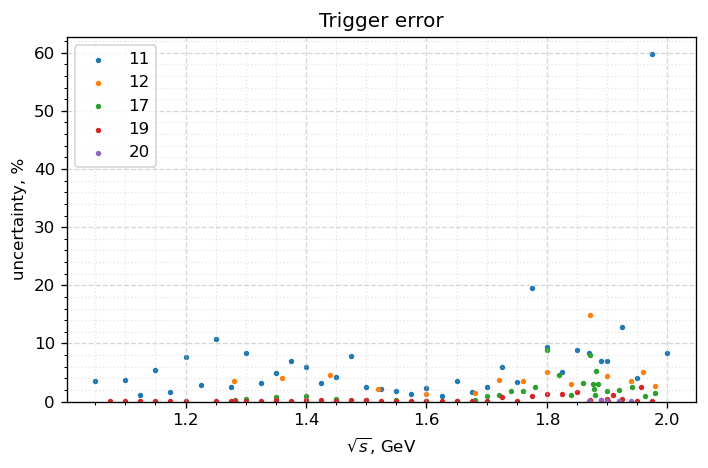

In [6]:
for s in cs:
    stat_err = cs[s]['eff_trig_err']/cs[s]['eff_trig']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'Trig Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('Trigger error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### MC

MC Error season 11: mean 4.4%, median 4.4%
MC Error season 12: mean 5.1%, median 5.0%
MC Error season 17: mean 5.3%, median 5.2%
MC Error season 19: mean 4.6%, median 4.5%
MC Error season 20: mean 7.0%, median 6.5%


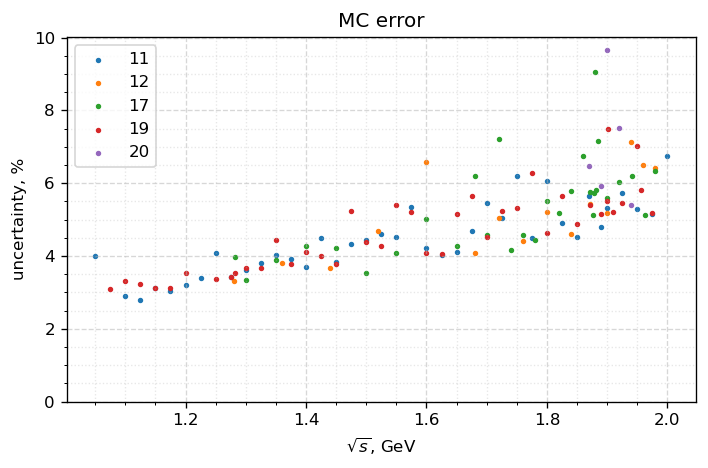

In [7]:
for s in cs:
    stat_err = cs[s]['eff0_err']/cs[s]['eff0']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'MC Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('MC error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### DC corr

MC Error season 11: mean 5.0%, median 5.0%
MC Error season 12: mean 9.2%, median 9.2%
MC Error season 17: mean 5.9%, median 5.9%
MC Error season 19: mean 3.2%, median 3.2%
MC Error season 20: mean 12.7%, median 12.8%


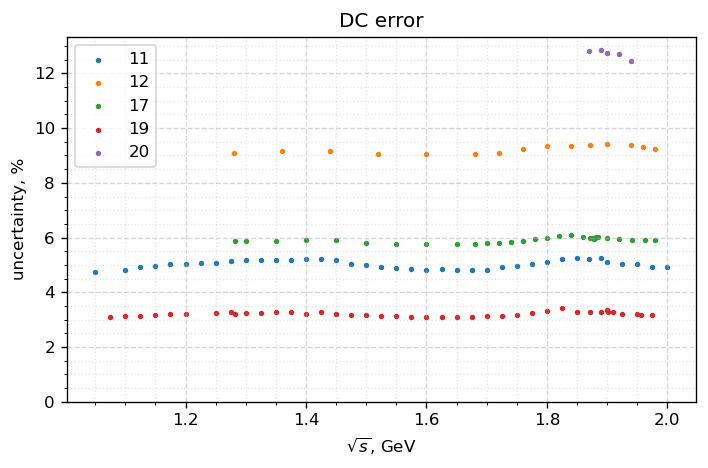

In [36]:
for s in cs:
    stat_err = cs[s]['dccorr_err']/cs[s]['dccorr']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'MC Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('DC error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### Светимость (статистическая ошибка светимости?)

MC Error season 11: mean 0.3%, median 0.3%
MC Error season 12: mean 0.3%, median 0.3%
MC Error season 17: mean 0.2%, median 0.2%
MC Error season 19: mean 0.2%, median 0.2%
MC Error season 20: mean 0.1%, median 0.1%


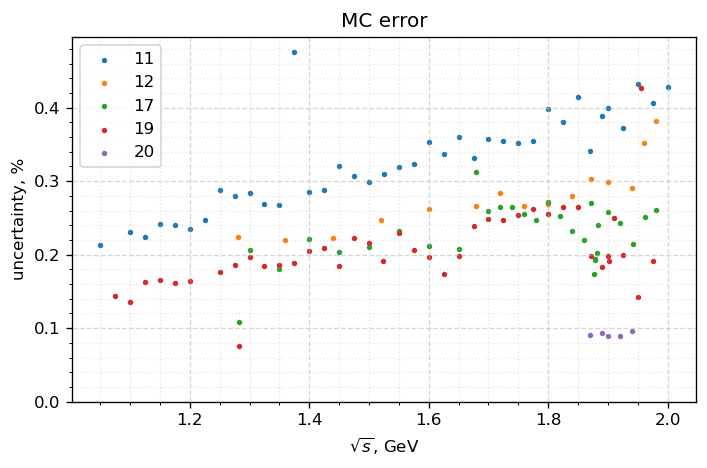

In [9]:
for s in cs:
    stat_err = cs[s]['lum_err']/cs[s]['lum']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'MC Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('MC error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### Рад. поправки
Вопрос, как оценить ошибку радпоправок, т.к. в ней сидит эффективность, все параметры которой имеют ошибки, да ещё и ошибки соседних точек при аппроксимации

### Критерии отбора
Варьировать отборы, посмотреть влияние

### Ошибки определения числа событий
Посмотреть разные фиты для фона (константа, линия, полином)


In [10]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM

def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 2*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

def cutter_tree(df, z_cut, align_cut):
    df2 = df.loc[(np.abs(df['tz[0]'])<z_cut)&(np.abs(df['tz[1]'])<z_cut)&(df['ksalign']>align_cut)].copy()
    return df2

In [11]:
from progressbar import progressbar

In [12]:
def rand_sys(SEASON, max_samples=4, poly_deg=[0, 1],
             z_var=[10, 12, 14], align_var=[0.7, 0.8, 0.85], 
             xmin_var=[-45, -40, -30], xmax_var=[15, 20, 25]):
    exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
    mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
    df_exp0 = preprocess.read_tree(exp_tree, mc=False, z_cut=max(z_var), align_cut=min(align_var))
    df_mc0 = preprocess.read_tree(mc_tree, mc=True, z_cut=max(z_var), align_cut=min(align_var))
    sampler = lambda x: np.random.choice(x, max_samples)
    samps = {'z' : sampler(z_var),
             'align' : sampler(align_var),
             'xmin' : sampler(xmin_var),
             'xmax' : sampler(xmax_var),
             'polynom' : sampler(poly_deg),
            }
    samples = np.unique(np.concatenate([samps[s].reshape(1, -1) for s in samps]), axis=1).T
    inference = pd.DataFrame(columns=[f'sample_{i+1}' for i in range(len(samples))])
    
    print(f'Number of samples: {len(samples)}')
    for i, sample in enumerate(samples):
        samp_dict = dict(zip(samps.keys(), sample))
        print(f'{i+1:2} Sample', samp_dict)
        
        df_exp = cutter_tree(df_exp0, samp_dict['z'], samp_dict['align'])
        df_mc = cutter_tree(df_mc0, samp_dict['z'], samp_dict['align'])
        
        energies_list = df_exp.index.unique().intersection(df_mc.index.unique())
        
        fit_range = (samp_dict['xmin'], samp_dict['xmax'])
        params = {
            'n_sig': (2000, (0.1, None)),
            'm'    : (   0, (-5, 5)),
            'sL'   : (   2, (1, 10)),
            'sR'   : (   5, (1, 10)),
            'aL'   : (   0, (0, 10)),
            'aR'   : (   0, (0, 10)),
            'y0'   : (   0.1, (0, None)),
            'dy'   : (   0.1, (0, None)),
        }
        
        for energy in energies_list:
#             print(f'Fitting {SEASON} | {energy} MeV')
            dfE, dfM = get_x1(df_exp, df_mc, energy)
            dataE, dataM = dfE.x1.values, dfM.x1.values
            
            m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
            m_mc.simplex().migrad(iterate=20).hesse()
            if not(m_mc.valid):
                print(f'MC FIT NOT VALID')

            params_exp = get_params_exp(params, m_mc, ['n_sig', 'y0', 'y1', 'm'])
            if samp_dict['polynom']<0.1:
                params_exp['dy'] = (0., (0, 0))
            elif samp_dict['polynom']<1.1:
                params_exp['dy'] = (0.3, (0, None))
            m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
            try:
                m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse()
                if not(m_exp.valid):
                    print(f'EXP FIT NOT VALID')
                inference.at[energy, f'sample_{i+1}'] = m_exp.values["n_sig"]/m_mc.values["n_sig"]
            except:
                print('Fit problem')
                inference.at[energy, f'sample_{i+1}'] = np.NAN
                
#             print(f' Exp/MC: {m_exp.values["n_sig"]:8.2f}/{m_mc.values["n_sig"]:8.2f}')
        
    return inference

In [13]:
SEASON = '12'

In [14]:
%%time
sys_errs = rand_sys(SEASON, max_samples=30)

Number of samples: 28
 1 Sample {'z': 10.0, 'align': 0.7, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 0.0}
 2 Sample {'z': 10.0, 'align': 0.7, 'xmin': -30.0, 'xmax': 20.0, 'polynom': 1.0}
 3 Sample {'z': 10.0, 'align': 0.7, 'xmin': -30.0, 'xmax': 25.0, 'polynom': 1.0}
Fit problem
 4 Sample {'z': 10.0, 'align': 0.8, 'xmin': -45.0, 'xmax': 15.0, 'polynom': 0.0}
 5 Sample {'z': 10.0, 'align': 0.8, 'xmin': -45.0, 'xmax': 20.0, 'polynom': 0.0}
 6 Sample {'z': 10.0, 'align': 0.8, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 0.0}
 7 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 15.0, 'polynom': 0.0}
 8 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 15.0, 'polynom': 1.0}
 9 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 20.0, 'polynom': 1.0}
10 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 0.0}
11 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 1.0}
12 Sample {'z': 10.0, 'align': 0.85, 'xmin': -30.0, 'xmax': 15.0, 'pol

In [20]:
real = ((cs[SEASON]['n_sig_exp']/cs[SEASON]['n_sig_mc'])/sys_errs.T.mean()).dropna()

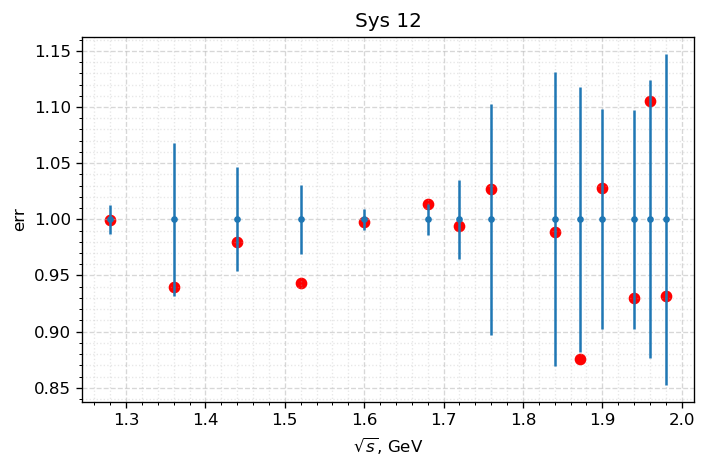

In [21]:
plt.errorbar(sys_errs.index*2e-3, sys_errs.T.mean()/sys_errs.T.mean(), yerr=sys_errs.T.std()/sys_errs.T.mean(), fmt='.')
plt.scatter(real.index*2e-3, real, c='r')
pys.my_style(f'Sys {SEASON}', '$\sqrt{s}$, GeV', 'err');

In [13]:
sys_errs = rand_sys('19', max_samples=10)
real = ((cs['19']['n_sig_exp']/cs['19']['n_sig_mc'])/sys_errs.T.mean()).dropna()

Number of samples: 9
 1 Sample {'z': 10.0, 'align': 0.8, 'xmin': -45.0, 'xmax': 15.0, 'polynom': 1.0}
 2 Sample {'z': 10.0, 'align': 0.8, 'xmin': -40.0, 'xmax': 15.0, 'polynom': 1.0}
 3 Sample {'z': 10.0, 'align': 0.8, 'xmin': -30.0, 'xmax': 15.0, 'polynom': 1.0}
 4 Sample {'z': 10.0, 'align': 0.85, 'xmin': -40.0, 'xmax': 20.0, 'polynom': 0.0}
 5 Sample {'z': 10.0, 'align': 0.85, 'xmin': -30.0, 'xmax': 20.0, 'polynom': 0.0}
 6 Sample {'z': 12.0, 'align': 0.7, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 1.0}
 7 Sample {'z': 12.0, 'align': 0.8, 'xmin': -40.0, 'xmax': 20.0, 'polynom': 1.0}
 8 Sample {'z': 12.0, 'align': 0.8, 'xmin': -30.0, 'xmax': 25.0, 'polynom': 1.0}
 9 Sample {'z': 14.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 0.0}


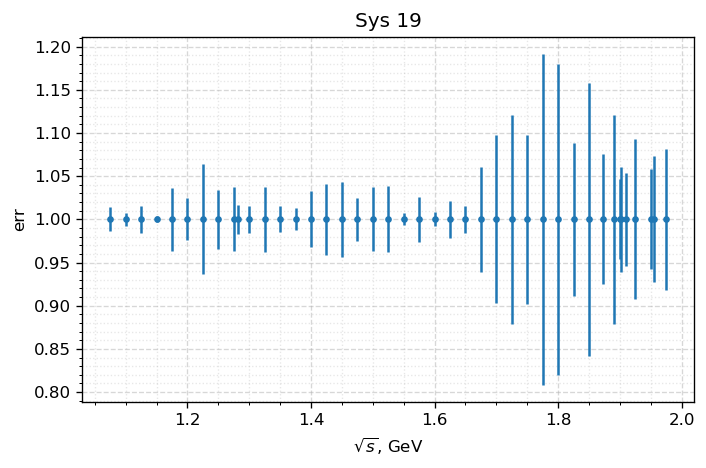

In [41]:
plt.errorbar(sys_errs.index*2e-3, sys_errs.T.mean()/sys_errs.T.mean(), yerr=sys_errs.T.std()/sys_errs.T.mean(), fmt='.')
# plt.scatter(real.index*2e-3, real, c='r')
pys.my_style(f'Sys 19', '$\sqrt{s}$, GeV', 'err');

Отбор по $\rho$

In [37]:
SEASON='11'
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False, z_cut=12, align_cut=0.8)
df_mc = preprocess.read_tree(mc_tree, mc=True, z_cut=12, align_cut=0.8)

In [38]:
df_exp.index.unique()

Float64Index([ 525.0,  537.5,  550.0,  562.5,  575.0,  587.5,  600.0,  612.5,
               625.0,  637.5,  650.0,  662.5,  675.0,  687.5,  700.0,  712.5,
               725.0,  737.5,  750.0,  762.5,  775.0,  787.5,  800.0,  812.5,
               825.0,  837.5,  850.0,  862.5,  875.0,  887.5,  900.0,  912.5,
               925.0,  935.0,  945.0,  950.0,  962.5,  975.0,  987.5, 1000.0],
             dtype='float64', name='ebeam')

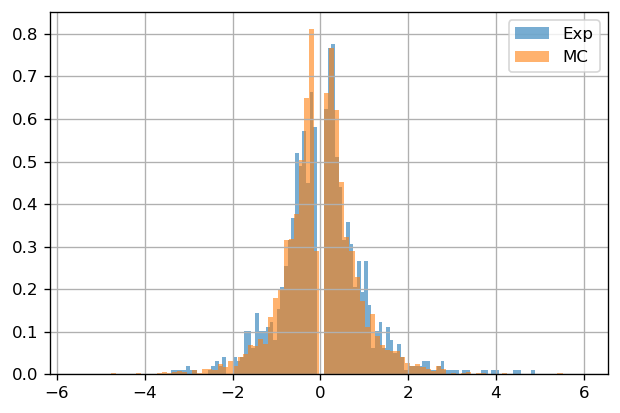

In [45]:
df_exp.loc[550, 'trho[0]'].hist(bins=100, density=True, alpha=0.6, label='Exp');
df_mc.loc[550, 'trho[0]'].hist(bins=100, density=True, alpha=0.6, label='MC');
plt.legend();

In [46]:
e0 = 550

$|\rho| < 0.1$ - стандарт

In [48]:
fit_range = (-40, 20)
params = {
    'n_sig': (2000, (0.1, None)),
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'y0'   : (   0.1, (0, None)),
    'dy'   : (   0.1, (0, None)),
}

dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20).hesse();
params_exp = get_params_exp(params, m_mc, ['n_sig', 'y0', 'y1', 'm'])
m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse();

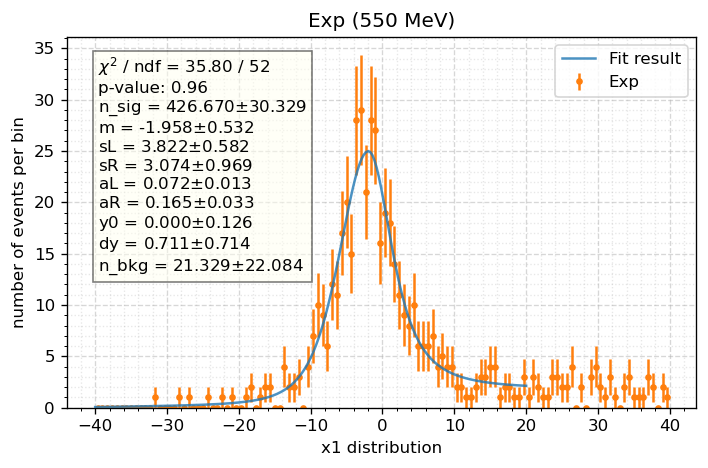

In [49]:
hist_range=(-40, 40)
def plot_fit_data(save=False):
#     pys.plot_fit(dataM, cost_mc, m_mc, 120, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution', alpha=0.8,
#                ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)#, bbox_color=None, fit_color='#CC6FD9', data_color='#9AD9C8')
# #     plt.grid(ls=':', alpha=0.2)
#     if save:
#         if not(os.path.isdir(f'images/fit{SEASON}')):
#             os.mkdir(f'images/fit{SEASON}')
#         plt.savefig(f'images/fit{SEASON}/mc_{e0}.png', dpi=120)

    pys.plot_fit(dataE, cost_exp, m_exp, 120, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution', alpha=0.8,
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True, fill_errors=False)#, bbox_color=None, fit_color='#CC6FD9', data_color='#8C7B48')
#     plt.grid(alpha=0.2)
    if save:
        plt.savefig(f'images/fit{SEASON}/exp_{e0}.png', dpi=120)
plot_fit_data(False)

In [50]:
val0 = m_exp.values['n_sig']/m_mc.values['n_sig']

$|\rho| > 0.2$

In [52]:
rho_cutter = lambda df, rcut: df.loc[(np.abs(df['trho[0]'])>rcut)&(np.abs(df['trho[1]'])>rcut)].copy()

fit_range = (-40, 20)
params = {
    'n_sig': (2000, (0.1, None)),
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'y0'   : (   0.1, (0, None)),
    'dy'   : (   0.1, (0, None)),
}

dfE, dfM = get_x1(rho_cutter(df_exp, 0.22), rho_cutter(df_mc, 0.22), e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20).hesse();
params_exp = get_params_exp(params, m_mc, ['n_sig', 'y0', 'y1', 'm'])
m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse();

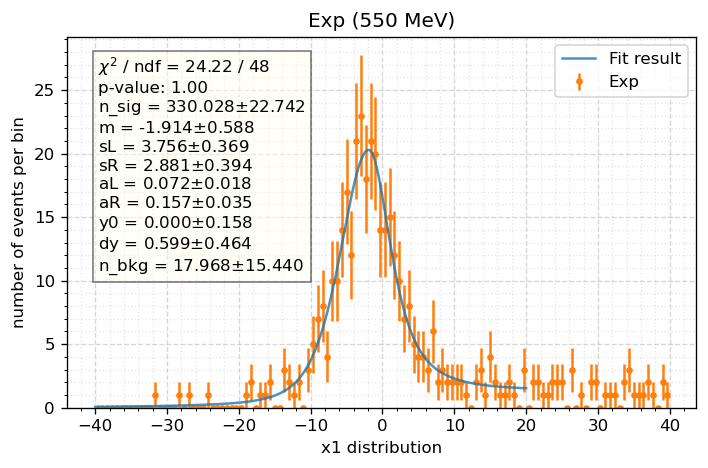

In [53]:
plot_fit_data(False)

In [54]:
val1 = m_exp.values['n_sig']/m_mc.values['n_sig']

In [55]:
(val0 - val1)/val0/np.sqrt(2)

-0.004465173727025293

In [56]:
def rho_sys(rho_cut=0.1):
    fit_range = (-40, 20)
    params = {
        'n_sig': (2000, (0.1, None)),
        'm'    : (   0, (-5, 5)),
        'sL'   : (   2, (1, 10)),
        'sR'   : (   5, (1, 10)),
        'aL'   : (   0, (0, 10)),
        'aR'   : (   0, (0, 10)),
        'y0'   : (   0.1, (0, None)),
        'dy'   : (   0.1, (0, None)),
    }

    dfE, dfM = get_x1(rho_cutter(df_exp, rho_cut), rho_cutter(df_mc, rho_cut), e0)
    dataE, dataM = dfE.x1.values, dfM.x1.values

    m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
    m_mc.simplex().migrad(iterate=20).hesse();
    params_exp = get_params_exp(params, m_mc, ['n_sig', 'y0', 'y1', 'm'])
    m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
    m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse();
    return m_exp.values['n_sig']/m_mc.values['n_sig']

In [57]:
xx = np.linspace(0.1, 0.4, 30)
yy = [(rho_sys(x) - val0)/val0 for x in xx]

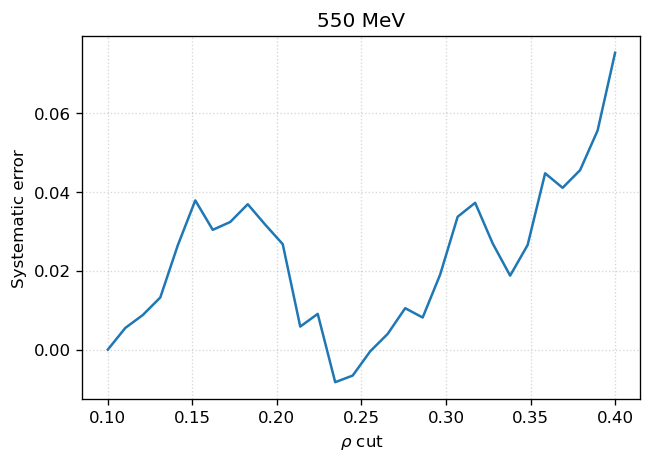

In [58]:
plt.plot(xx, yy)
plt.grid(ls=':', alpha=0.5);
plt.title(f'{e0} MeV')
plt.ylabel('Systematic error')
plt.xlabel('$\\rho$ cut');

In [21]:
# SEASON='11'
mc_tree = uproot.open('/store17/petrov/data/kskl20/tr_ph/11/tr_ph_kskl_550_9158.root')['tr_ph']
# df_mc0 = preprocess.read_tree(mc_tree, mc=True, z_cut=12, align_cut=0.8)

In [35]:
mc_tree.arrays(['simvtx', 'simvty', 'simorig', 'simtype'], library='pd')

simvtx    simvty  simorig  simtype
entry subentry                                      
0     0         0.031785 -0.019853        0      130
      1         0.031785 -0.019853        0      310
      2         0.031785 -0.019853        0       22
1     0         0.030466 -0.019757        0      130
      1         0.030466 -0.019757        0      310
...                  ...       ...      ...      ...
19998 0         0.030132 -0.016170        0      130
      1         0.030132 -0.016170        0      310
      2         0.030132 -0.016170        0       22
19999 0         0.028522 -0.016003        0      130
      1         0.028522 -0.016003        0      310

[51056 rows x 4 columns]